<!-- metadata: title -->
# Kenya Unit Trusts: Money Market Fund(KES) Analysis

<!-- metadata: subtitle -->
> ### Can Kenyan Money Market Funds gurantee capital preservation? 

<!-- metadata: date, type=date -->
**Published Date:**
2024-03-03

<!-- metadata: date-modified, type=date-->
**Date Modified:**
2024-05-05

<!-- metadata: keywords, type=array -->
**Keywords:**
  - money
  - kenya
  - unit-trusts
  - money-market-funds
  - MMF

<!-- metadata: categories, type=array -->
**Categories:**
  - kenya-unit-trusts
  - money-market-funds

## Description

<!-- metadata: description -->
Money market is a form of unit trust, where fund managers collect money from the group of investors, and invest on their behave. This reduces the overhead of managing your portfio and significantly reduces your risk. Let's statistically and critically analyze Money market funds in Kenya in general using publicly available information and hopefully paint a clearer picture of the state of unit trusts in Kenya. 

- What are the risk factors that exist? 
- What is the performance of money market funds?

## Abstract

<!-- metadata: abstract -->
Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

## Introduction

In Kenya, a good number of the population have a bank account, even if not the traditional bank account. It is estimated that by year 2029, 99.9% of Kenyans will be banked, ^[Population share with banking account in Kenya 2014-2029
Published by J. Degenhard, Jan 30, 2024. <https://www.statista.com/forecasts/1149636/bank-account-penetration-forecast-in-kenya>]. With increase in financial access, financial literacy and regular individuals will want to venture in the teritory of finantial assets huunting for higher interest rates. One of the most attractive entry level high-yield financial asset is the unit trust, specifically the money market funds. Its easy to start, deposit, withdraw, and its interest is daily compunding, while offering higher interest than any bank.

## Analysis

### Imports

In [1]:
import sys
import os

# Add parent directory to sys.path
root_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(root_dir)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pyppeteer.page import Page
import asyncio
from utils.web_screenshot import web_screenshot

### Crawl the fund managers

Let's start of by listing all the certified fund mangers in Kenya by CMA.^[Approved Fund Managers by CMA. <https://www.cma.or.ke/licensees-market-players/>]

Lets start with a screenshot of the webpage.

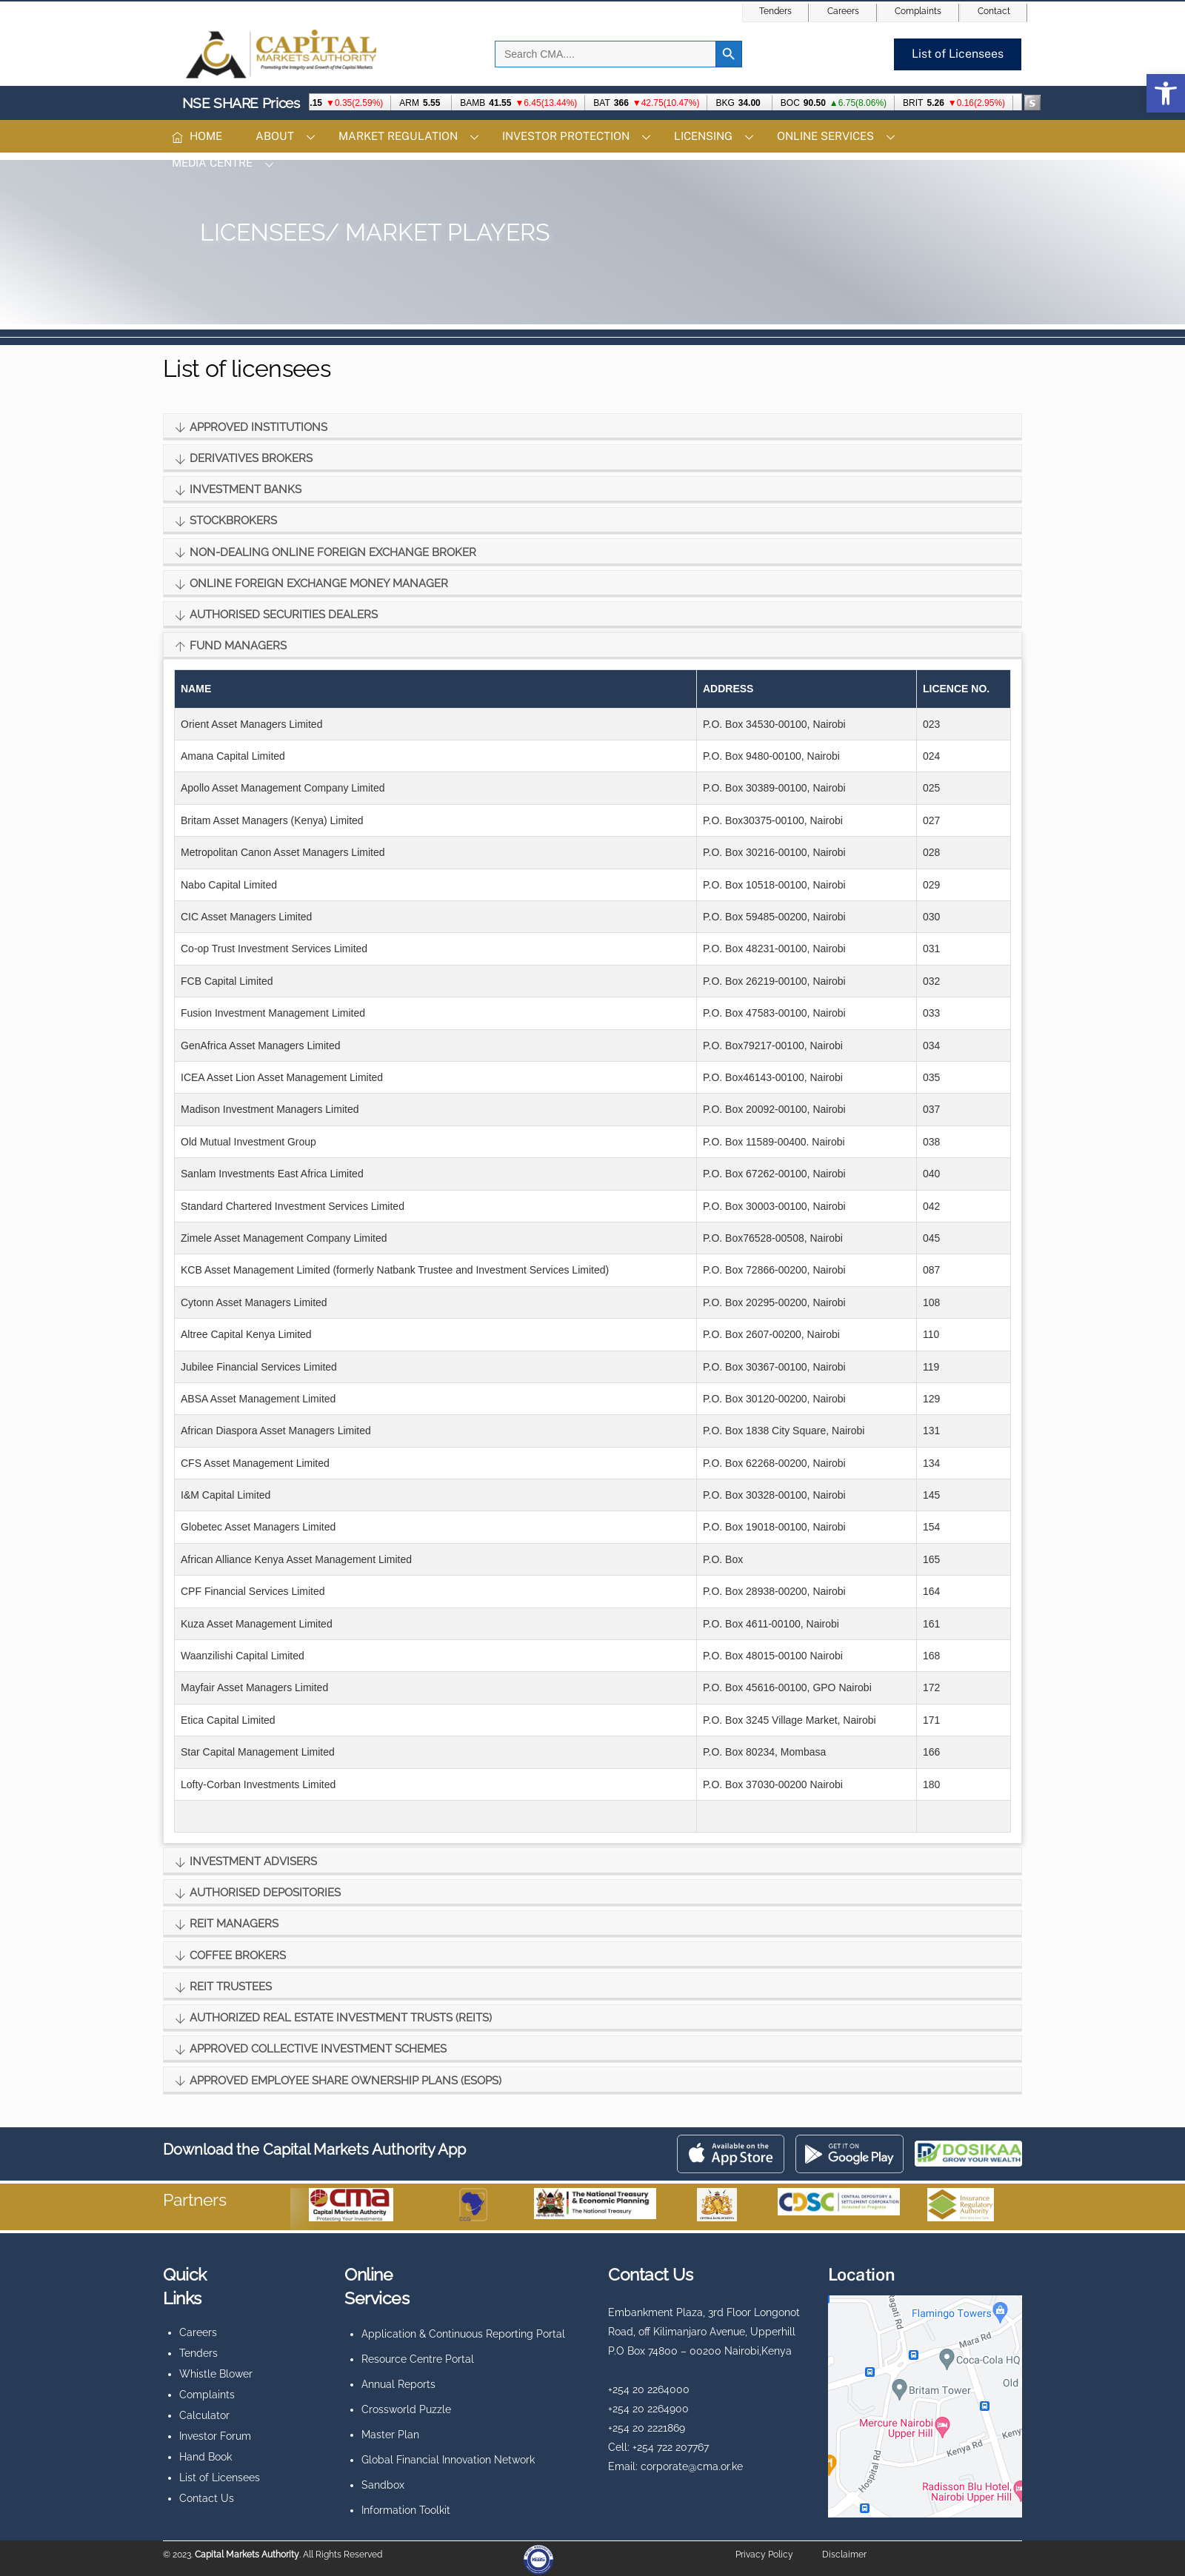

In [5]:
async def action(page: Page):
    await page.waitForSelector('ul.module-accordion')
    elements = await page.querySelectorAll('li .accordion-title')
    # Iterate through the elements to find the one containing 'FUND MANAGERS'
    for element in elements:
        text_content = await page.evaluate('(element) => element.textContent', element)
        if 'FUND MANAGERS' in text_content:
            # Click on the target element
            await element.click()
            break
    else:
        print('Element not found')
    await page.waitForSelector('li.current.builder-accordion-active')
    await asyncio.sleep(1)

web_screenshot(
    "https://www.cma.or.ke/licensees-market-players/", 
    action = action)

Let's query the "Fund Managers" table.

In [ ]:
import io
from bs4 import BeautifulSoup
from urllib.request import urlopen

html_content = urlopen("https://www.cma.or.ke/licensees-market-players/").read()
fund_managers_html_table = BeautifulSoup(html_content, "html.parser")\
    .find('span', string="FUND MANAGERS")\
        .parent\
            .parent\
                .parent\
                    .find('table')

fund_managers = pd.read_html(io.StringIO(str(fund_managers_html_table)))[0].dropna()
fund_managers

The address of `African Alliance Kenya Asset Management Limited` doesnt seem to be valid, ad soPO Box 27639 Nairobi 00506